In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# npois = 29071
# nspus = 179778

npois = 29924
nusers = 200000
# nspus = 195244

In [3]:
datapath = "../data/SMP新数据-20210607-20210702/"
d_session = pd.read_csv(datapath+"orders_poi_session.txt", sep='\t')
d_train = pd.read_csv(datapath+"orders_train.txt", encoding="utf-8", sep='\t')
d_test = pd.read_csv(datapath + "orders_test_poi.txt", encoding="utf-8", sep='\t')

In [4]:
d_session.head()

,wm_order_id,clicks,dt
0,1103,2168#1884,20210607
1,24171,NaN,20210607
2,27913,1371#1494#3518,20210607
3,24875,1901#1901#1901#1901#2398,20210607
4,23149,NaN,20210607


In [5]:
d_train.head()

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
0,178557,0,2334,6,<29,1623061539,3,0,NaN,未知,20210607
1,175118,1,3315,0,<29,1623032193,1,1,0.0,0,20210607
2,36208,2,2168,0,<29,1623036350,1,0,1.0,0,20210607
3,102798,3,3071,0,"[29,36)",1623071723,4,0,2.0,0,20210607
4,73712,4,2902,0,"[49,65)",1623020472,0,2,3.0,1,20210607


In [19]:
print(d_train.shape, d_session.shape, d_test.shape)
print(d_train.isna().sum(axis=0))

(1071873, 11) (1303169, 3)
user_id                       0
wm_order_id                   0
wm_poi_id                     0
aor_id                        0
order_price_interval          0
order_timestamp               0
ord_period_name               0
order_scene_name              0
aoi_id                    54155
takedlvr_aoi_type_name        0
dt                            0
dtype: int64


In [4]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071873 entries, 0 to 1071872
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   user_id                 1071873 non-null  int64  
 1   wm_order_id             1071873 non-null  int64  
 2   wm_poi_id               1071873 non-null  int64  
 3   aor_id                  1071873 non-null  int64  
 4   order_price_interval    1071873 non-null  object 
 5   order_timestamp         1071873 non-null  int64  
 6   ord_period_name         1071873 non-null  int64  
 7   order_scene_name        1071873 non-null  object 
 8   aoi_id                  1017718 non-null  float64
 9   takedlvr_aoi_type_name  1071873 non-null  object 
 10  dt                      1071873 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 90.0+ MB


In [8]:
d_train.describe(include='all')

,user_id,wm_order_id,wm_poi_id,aor_id,order_price_interval,order_timestamp,ord_period_name,order_scene_name,aoi_id,takedlvr_aoi_type_name,dt
count,1.071873e+06,1.071873e+06,1.071873e+06,1.071873e+06,1071873,1.071873e+06,1.071873e+06,1071873,1.017718e+06,1071873,1.071873e+06
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,10,NaN,13,NaN
top,NaN,NaN,NaN,NaN,<29,NaN,NaN,0,NaN,0,NaN
freq,NaN,NaN,NaN,NaN,468813,NaN,NaN,529986,NaN,563140,NaN
mean,1.000228e+05,5.359360e+05,1.777230e+03,4.439300e+00,NaN,1.623924e+09,1.840656e+00,NaN,1.009528e+03,NaN,2.021062e+07
std,5.769536e+04,3.094232e+05,1.043924e+03,3.464722e+00,NaN,5.238255e+05,1.158654e+00,NaN,7.782196e+02,NaN,6.060936e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.622995e+09,0.000000e+00,NaN,0.000000e+00,NaN,2.021061e+07
25%,5.013900e+04,2.679680e+05,8.680000e+02,1.000000e+00,NaN,1.623468e+09,1.000000e+00,NaN,3.260000e+02,NaN,2.021061e+07
50%,1.000340e+05,5.359360e+05,1.804000e+03,5.000000e+00,NaN,1.623929e+09,1.000000e+00,NaN,8.540000e+02,NaN,2.021062e+07
75%,1.500410e+05,8.039040e+05,2.674000e+03,8.000000e+00,NaN,1.624366e+09,3.000000e+00,NaN,1.687000e+03,NaN,2.021062e+07


In [5]:
d_test.describe(include='all')

(168546, 8)


,user_id,wm_order_id,aor_id,order_timestamp,ord_period_name,aoi_id,takedlvr_aoi_type_name,dt
count,168546.000000,1.685460e+05,168546.000000,1.685460e+05,168546.000000,161142.000000,168546,1.685460e+05
unique,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,85179,NaN
mean,100271.585698,1.177108e+06,4.395032,1.625032e+09,1.813730,1022.164153,NaN,2.021066e+07
std,57684.884797,6.100667e+04,3.488756,1.247021e+05,1.137473,794.212080,NaN,3.544080e+01
min,0.000000,1.071874e+06,0.000000,1.624810e+09,0.000000,0.000000,NaN,2.021063e+07
25%,50524.000000,1.123957e+06,1.000000,1.624936e+09,1.000000,330.000000,NaN,2.021063e+07
50%,100338.500000,1.177038e+06,4.000000,1.625026e+09,1.000000,863.000000,NaN,2.021063e+07
75%,150272.000000,1.230027e+06,8.000000,1.625135e+09,3.000000,1691.000000,NaN,2.021070e+07


In [18]:
print(
    d_test['aor_id'].unique(),
    d_test['ord_period_name'].unique(),
    d_test['aoi_id'].unique(), d_test['aoi_id'].isna().sum(),
    d_test['takedlvr_aoi_type_name'].unique(),
)

print(d_train['order_price_interval'].unique())

[ 5  6  4  3  7  8  9  0  2  1 10] [4 1 2 3 0] [  nan  412. 1822. ... 2748. 3520. 3199.] 7404 ['未知' '3' '0' '5' '11' '7' '1' '10' '9' '8' '4' '6' '2']
['<29' '[29,36)' '[49,65)' '>=65' '[36,49)']


In [24]:
# print(d_test.isna().sum(axis=0))
print([d_train[c].unique() for c in ['aoi_id', 'takedlvr_aoi_type_name', 'order_scene_name']])

[array([      nan, 0.000e+00, 1.000e+00, ..., 3.621e+03, 3.622e+03,
       3.623e+03]), array(['未知', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype=object), array(['0', '1', '2', '3', '4', '5', '未知', '6', '7', '8'], dtype=object)]


In [20]:
print(d_train.wm_order_id.nunique(), d_test.wm_order_id.nunique(), \
d_test.drop_duplicates('wm_order_id').wm_order_id.isin(d_train.wm_order_id).sum())

(1071873, 168546, 0)

In [30]:
d_train.wm_order_id.max(), d_test.wm_order_id.max(), d_train.wm_order_id.count(), d_test.wm_order_id.count()


(1071872, 1282847, 1071873, 168546)

In [28]:
d_train.wm_order_id.sort_values(ascending=False).head(),
d_test.wm_order_id.sort_values(ascending=False).head(),

(168545    1282847
 168544    1282846
 168543    1282845
 168542    1282842
 168541    1282841
 Name: wm_order_id, dtype: int64,)

In [31]:
1071873+168546

1240419

In [40]:
d_train.wm_poi_id.nunique(), d_train.wm_poi_id.max()

(3526, 3576)

/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0.0, flags=flags)


<Figure size 432x288 with 0 Axes>

/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/textpath.py:65: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26410 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/easonshi/miniconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 30693 missing from current font.
  font.set_text(s, 0, flags=flags)


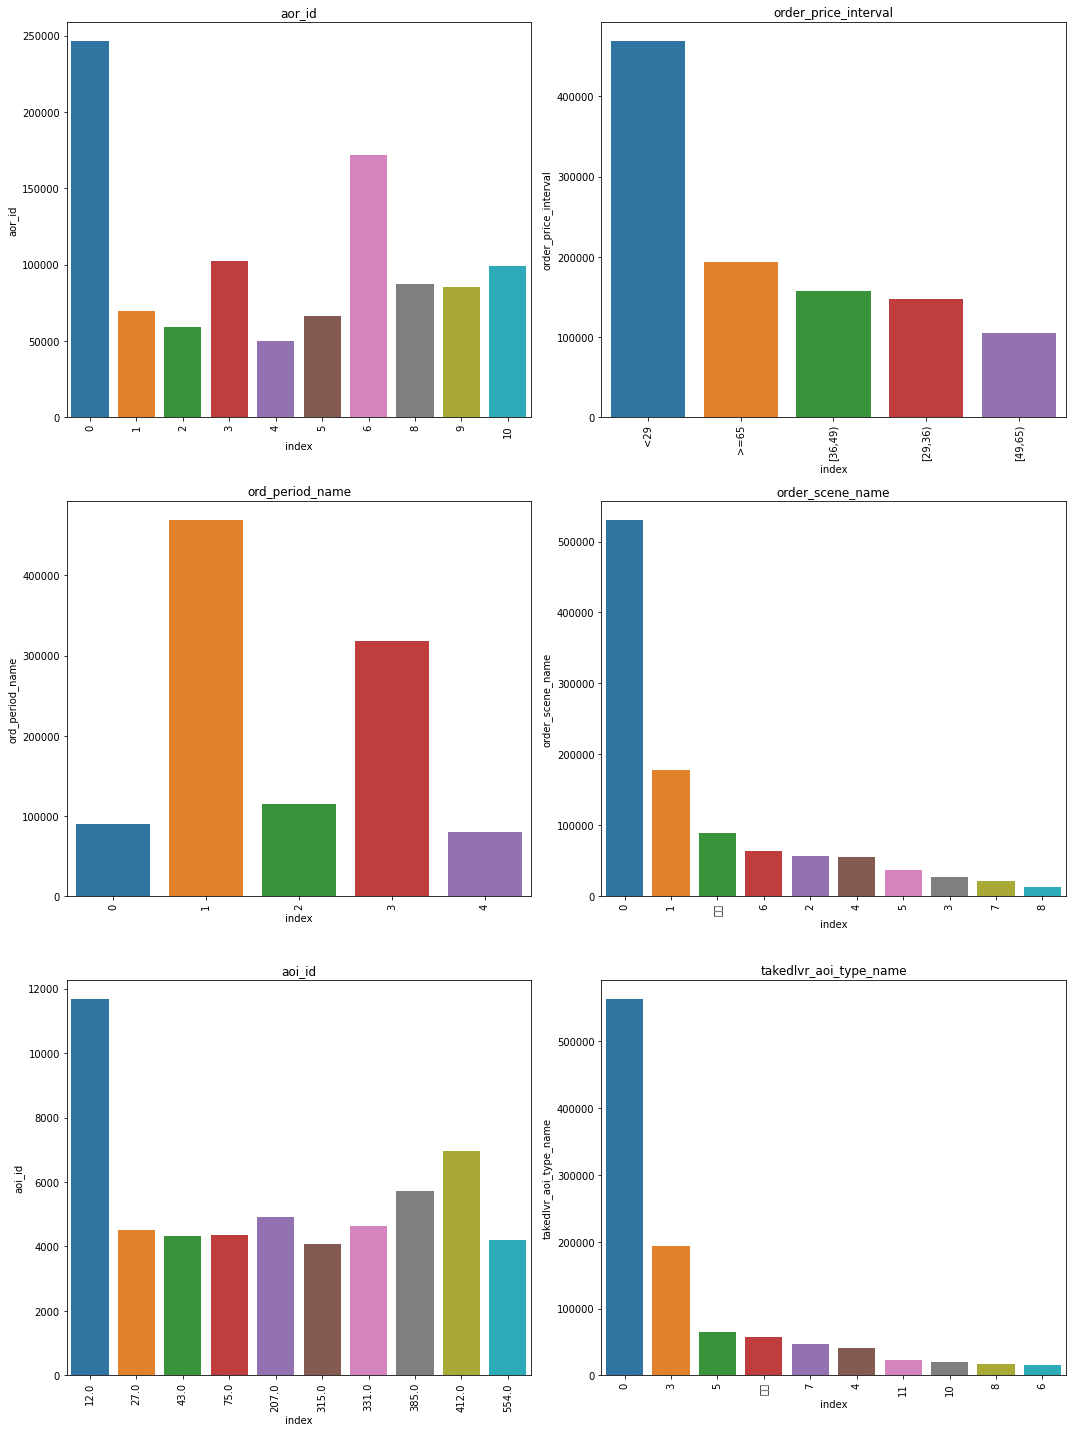

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['aor_id', 'order_price_interval', 'ord_period_name', 'order_scene_name', 'aoi_id', 'takedlvr_aoi_type_name']:
    plot_envs = plt.subplot(3, 2, i)
    i += 1
    v = d_train[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [36]:
d_train.aor_id.value_counts()

0     246279
6     171812
3     102033
10     99322
8      86951
9      85076
1      69802
5      66357
2      59090
4      49647
7      35504
Name: aor_id, dtype: int64

In [37]:
d_train.order_scene_name.value_counts()

0     529986
1     177313
未知     89595
6      63992
2      57433
4      54771
5      37533
3      26970
7      21301
8      12979
Name: order_scene_name, dtype: int64

## 用户分析




In [16]:
d_test.drop_duplicates('user_id').user_id.isin(d_train.user_id).sum()

91221